# AI - Carlos Dip

Análise do dataset sobre ecommerce no Brasil, fornecido pela olist, disponível no Kaggle em [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).

Esse dataset consiste em dados da empresa obtidos ao longo de 2 anos (2016 a 2018), com 100k reviews, e 33k produtos, distribuidos em 8 tabelas, seguindo o schema abaixo.

![](dataset_info.png)

In [1]:
# Imports e funções de apoio
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import urllib
import matplotlib.pyplot as plt

def plot_words(colection, n_palavras,title=None):
    palavras = [ t[1] for t in colection ]
    contagens = [ t[0] for t in colection ]
    eixo_x = np.arange(n_palavras)
    plt.figure(figsize=(18,6))
    if title:
        plt.title(title)
    plt.ylabel("Contagem Palavras")
    plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
    plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=90)
    plt.show()

def plot_combined(words, good, bad):
    n_palavras = len(words)
    eixo_x = np.arange(n_palavras)
    plt.figure(figsize=(18,6))
    plt.title("Probabilidades das palavras para cada classe classes")
    plt.ylabel("P(palavra | classe)")
    plt.bar(eixo_x[:n_palavras]-0.125, bad[:n_palavras],width=0.25,label='negativo',color='red')
    plt.bar(eixo_x[:n_palavras]+0.125, good[:n_palavras],width=0.25,label='positivo',color='green')
    plt.legend()
    plt.xticks(eixo_x[:n_palavras], words[:n_palavras], rotation=90)
    plt.show()

def compute_top_n_word_counts(series: pd.Series, n: int = 50, ngram_range = (1,3)):
    sw = []
    # sw = urllib.request.urlopen("https://gist.githubusercontent.com/alopes/5358189/raw/2107d809cca6b83ce3d8e04dbd9463283025284f/stopwords.txt").read().decode()
    # sw = sw.split(' ')
    [sw.append(x) for x in ['do', 'no', 'na', 'em', 'um', 'eu', 'só', 'na', 'foi', 'da', 'me', 'produto']]
    full_vec = CountVectorizer(ngram_range=ngram_range, stop_words=sw)
    z = full_vec.fit_transform(series)
    z = np.sum(z, axis=0)
    return sorted([(z[0,full_vec.vocabulary_[i]], i) for i in full_vec.vocabulary_.keys()], reverse=True)[:n]

def analyze(all_reviews, good_reviews, bad_reviews, n, ngram_range):
    top_50 = compute_top_n_word_counts(all_reviews, n,ngram_range=ngram_range)
    words = [t[1] for t in top_50]
    counts = [t[0] for t in top_50]
    all_bad = compute_top_n_word_counts(bad_reviews, -1,ngram_range=ngram_range)
    all_good = compute_top_n_word_counts(good_reviews, -1,ngram_range=ngram_range)
    good = []
    bad = []
    for w,c in zip(words, counts):
        for g in all_good:
            if g[1] == w:
                good.append(g[0]/c)
        for b in all_bad:
            if b[1] == w:
                bad.append(b[0]/c)
    if len(good) < len(words) or len(bad) < len(words):
        print("Sorry, ngram_range is too restrictive for this word amount, try allowing smaller ngrams or reducing n")
        return words, counts, counts
    plot_words(compute_top_n_word_counts(good_reviews, n, ngram_range=ngram_range), n, "N-Gramas para categoria positiva")
    plot_words(compute_top_n_word_counts(bad_reviews, n, ngram_range=ngram_range), n, "N-Gramas para categoria negativa")
    return words, good, bad

datasets = {}
for i in ["olist_orders_dataset.csv", "olist_order_reviews_dataset.csv"]:
    datasets[i.replace('.csv', '')] = pd.read_csv(f"dataset/{i}")

In [2]:
reviews = datasets['olist_order_reviews_dataset']
reviews['review_score'].describe()

count    99224.000000
mean         4.086421
std          1.347579
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64

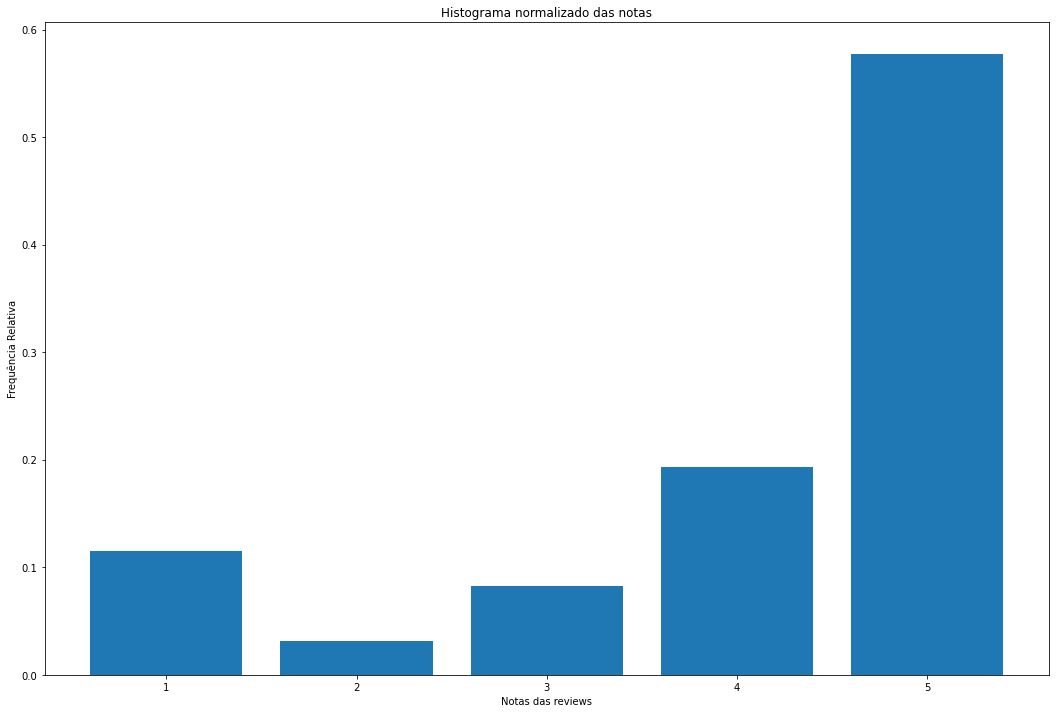

In [3]:
cnt = reviews['review_score'].value_counts()
plt.figure(figsize=(18,12))
plt.bar(x=cnt.index.to_list(), height=cnt/cnt.sum())
plt.xticks(range(1,6), range(1,6))
plt.ylabel("Frequência Relativa")
plt.xlabel("Notas das reviews")
plt.title("Histograma normalizado das notas")
plt.show()

Acima, pode-se observar a distribuição dos ratings dados pelos usuários. Como o primeiro quartil é em 4 (mais de 50% dos dados são 5), numa distribuição discreta de 1 a 5, pode-se dizer que existe um viés forte para notas altas, o que sugere que reviews são mais comuns entre pessoas satisfeitas. Ainda é possível que existam bots nesse contexto, ou seja, clientes que fazem centenas de reviews positivas para aumentar a credibilidade de um produto ou vendedor. O problema de identificação automática de bots é extremamente complexo, porém uma estratégia simples para identificar bots de spam é fazer uma contagem de reviews por usuário.

In [4]:
reviews_with_customer_id = pd.merge(left=reviews, right=datasets['olist_orders_dataset'][['order_id', 'customer_id']], how='left', left_on='order_id', right_on='order_id')
reviews_with_customer_id.value_counts(['customer_id'])

customer_id                     
2a35ad9f439dfc62d35a0202e71d6c66    3
9e29cde4ddb42f9330bcf3c9bc23d177    3
b7770073b02ed1d626a027ce86a4ff82    3
ae0fb7b01c548c4fd30f19f55453ec4a    3
a5dbb47a11f753332945a2acdf6e84c8    2
                                   ..
55cfce346990f14b5afce1b2a79cbbf7    1
55cf037bf8aab8f9546a9ef52eade642    1
55cec9069676ae68832c46af940b9f07    1
55cea14130c28e3aff86b47a695a0f13    1
ffffe8b65bbe3087b653a978c870db99    1
Length: 98673, dtype: int64

Para validar a confiabilidade dos reviews, é interessante fazer uma contagem do número de reviews de cada usuário, para evitar considerar reviews de usários com quantidade suspeita de reviews, como bots. Nesse dataset não parece ter sido um problema, então não é necessário filtrar.

## Análise exploratória

Inicialmente, para ter uma ideia melhor sobre como são os reviews disponíveis, foi decidido imprimir 10 exemplos das reviews mais positivas, e 10 exemplos das reviews mais negativas. Usando a ordenação do pandas, além do fatiamento de listas do python, isso pode ser realizado em algumas linhas.


In [5]:
reviews_with_message_ordered = reviews[reviews['review_comment_message'].notna()].reset_index().sort_values('review_score')['review_comment_message']
print("10 reviews positivos: \n{0}".format('\n'.join([x.replace('\n','').replace('\r','') for x in reviews_with_message_ordered[:-10:-1].to_list()])))
print("===========================================")
print("10 reviews negativos: \n{0}".format('\n'.join([x.replace('\n','').replace('\r','') for x in reviews_with_message_ordered[:10].to_list()])))

10 reviews positivos: 
Recebi bem antes do prazo estipulado.
Excelente e entrega super rápida 
Boa
OBRIGADO PELA ATENÇÃO MINHA COMPRA FOI ENTREGUE ATE ANTES DO PRAZO
Entregue antes do prazo pre-determinado. Excelente
Recebi td certinho antes do prazo! 
lannister é uma loja muito Boa,o produto chega sem problema e antes do prazo por isso recomendo ela,agora só me faltam 3 produto que comprei na mesma data de esse que recebi ontem. Muito obrigada. 
96% perfeito 
Estão de Parabéns, chegou antes do previsto 
10 reviews negativos: 
meu produto chegou e ja tenho que devolver, pois está com defeito , não segurar carga
Não recomendo, além da demora para entregar, chegou apenas uma cadeira, sendo que foi paga 2. Gostaria de saber, se posso abrir um processo, ou irão enviar a outra cadeira?
Não recebi o produto e enviei duas mesagens para o vendedor e nenhuma foi respondida, descaso total.
Produto comprado e não entregue no prazo. O fornecedor não deu satisfação a respeito do atraso.
O tipo de e

Analisando os exemplos acima, é possível criar uma hipótese, de que a maior questão em discussão acima é prazo (entrega atrasada) e fraude (não entrega). Ainda outro assunto um pouco mais pontual parece ser da qualidade dos items (cartuchos falsos para impressora, aparelho não pega carga) e quantidade de items (pedi x chegou y < x).

É possível que esses assuntos sejam pouco relevantes, e tenham aparecido aqui por coincidência. Por isso, analisar-se-à mais a fundo os dados, para tentar validar a hipótese mais.

## Classificação automática

Como existem quase 100000 reviews para analisar, classificá-las como positivo/negativo manualmente é inviável (como quase sempre é). Então, foi decidido usar o score fornecido.

In [6]:
reviews_with_comments = reviews[reviews['review_comment_message'].notna()]
reviews_with_comments

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01
...,...,...,...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,NaN,para este produto recebi de acordo com a compr...,2017-11-29 00:00:00,2017-11-30 15:52:51
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,NaN,Entregou dentro do prazo. O produto chegou em ...,2018-02-07 00:00:00,2018-02-19 19:47:23
99215,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,NaN,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00,2018-05-20 21:51:06
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43


Acima, são descartadas as reviews sem comentários, já que não é possível extrair dados acionáveis de reviews exclusivamente numéricos.

Para determinar se os reviews são positivos, inicialmente uma opção é usar o valor do review (de 1 a 5).

Como a distribuição é muito pesada para o lado do 5, decidiu-se usar 4 como ponto de corte, reviews com 5 são positivas, e o resto negativas.

In [7]:
MIN_GOOD_THRESHOLD = 5
good_reviews = reviews_with_comments[reviews_with_comments['review_score'] >= MIN_GOOD_THRESHOLD].reset_index()['review_comment_message']
bad_reviews = reviews_with_comments[reviews_with_comments['review_score'] < MIN_GOOD_THRESHOLD].reset_index()['review_comment_message']
all_reviews = reviews_with_comments.reset_index()['review_comment_message']

Acima, são extraídas as duas categorias de reviews, como Series do Pandas contendo strings.

## Análise de frequência

Para saber sobre o que estão falando as reviews positivas e negativas, pode ser interessante realizar uma simples análise de frequência de palavras.

Inicialmente, pareceu interessante realizar a análise com trigramas (já que já havia-se removido stopwords como preposições e artigos), na expectativa de encontrar estruturas mais capazes de produzir significado inteligível.

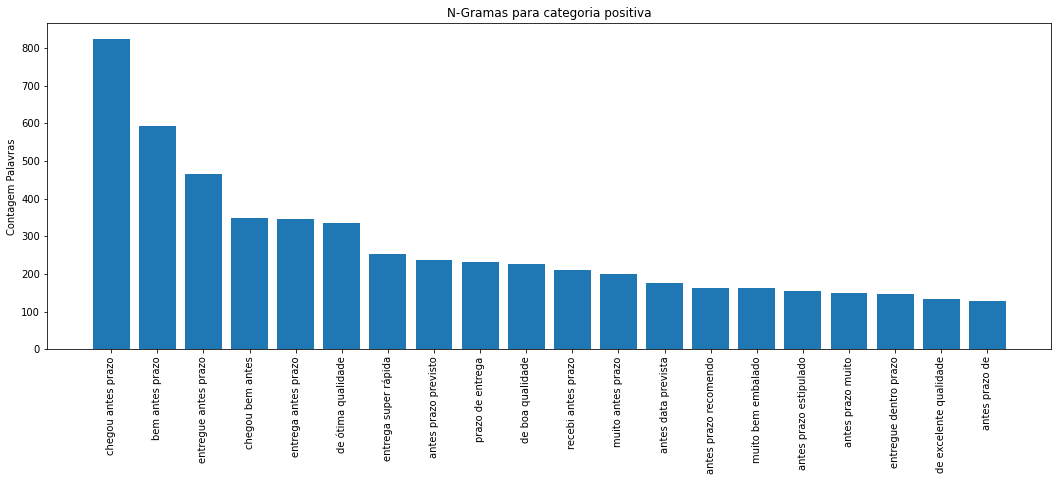

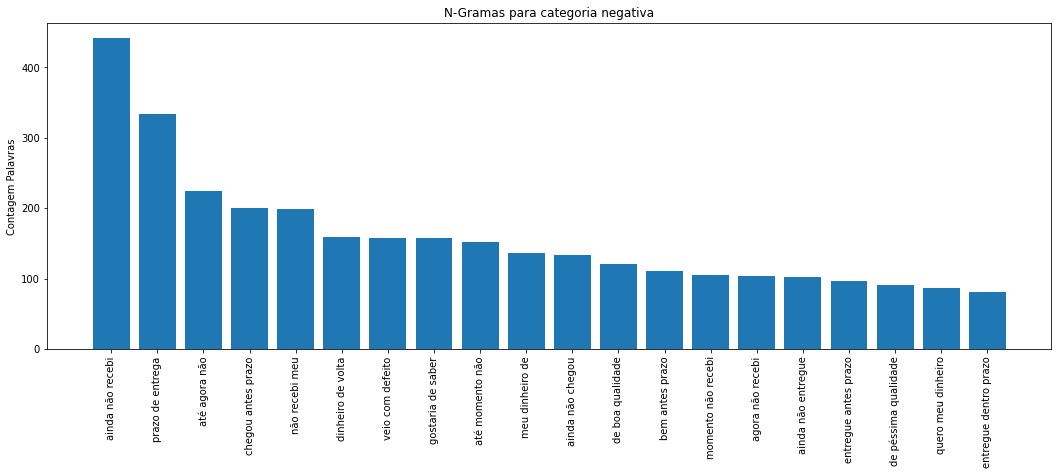

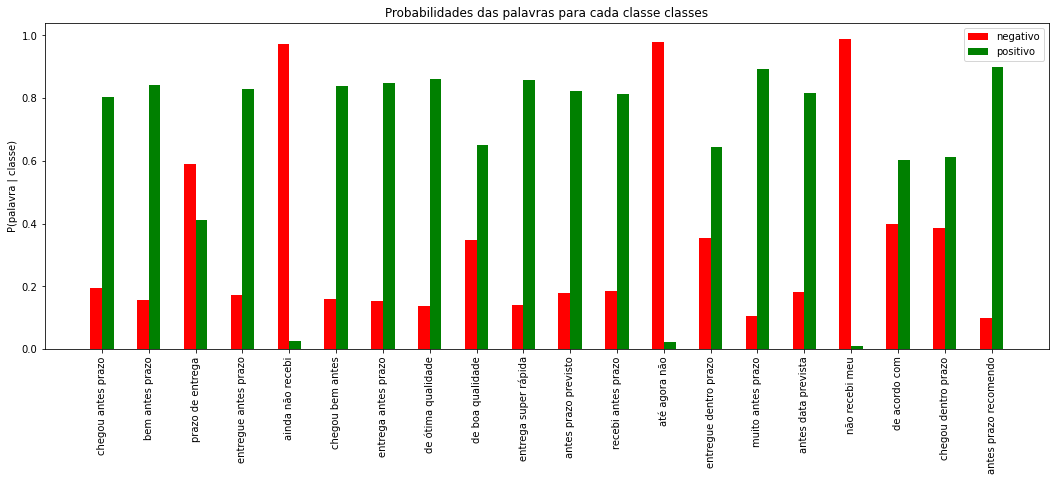

In [8]:
# Contabiliza palavras e constrói gráficos
plot_combined(*analyze(all_reviews,good_reviews,bad_reviews,n=20,ngram_range=(3,3)))

Os gráficos acima indicam as contagems absolutas dos termos mais populares nas duas categorias, e então as probablidade dos termos para as duas classes, respectivamente. Cada par de colunas (positivo/negativo) no terceiro gráfico soma 1 (100%).

Como é possível observar nos gráficos acima, para ngramas de tamanho 3, é possível identificar uma clara tendência de menções a prazos. Termos como "Ainda não recebi", "Até agora não" e "Não recebi meu" são de predominância quase absoluta na classe negativa de reviews. Já na classe positiva, temos opostos semânticos a esses, como "Recebi antes prazo", "Chegou antes prazo", "Entrega antes prazo", "Entrega super rápida" e "Chegou bem antes" etc.

A partir somente disso, já seria possível chegar a uma conclusão a respeito de questões acionáveis para a empresa. Contudo, é bom avaliar se esse tipo de análise se man´tem plausível para diferentes tamanhos de ngramas.

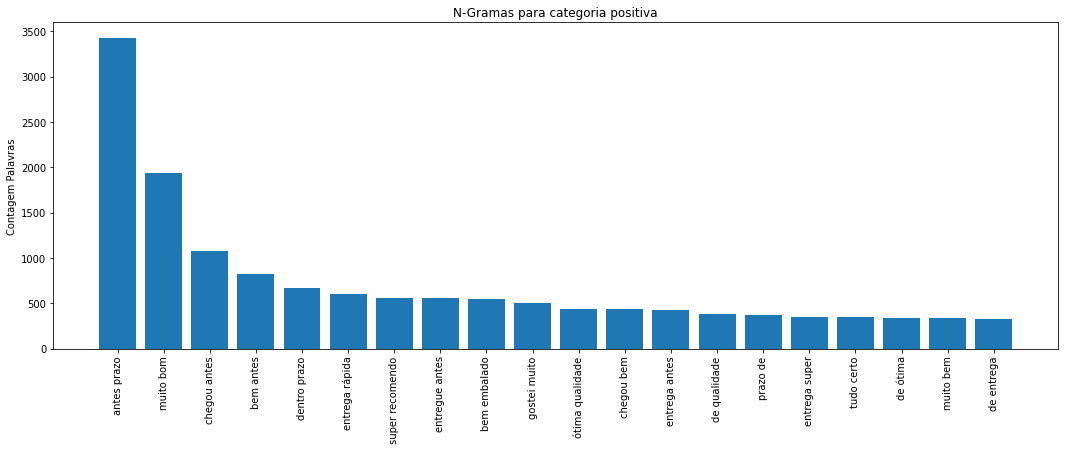

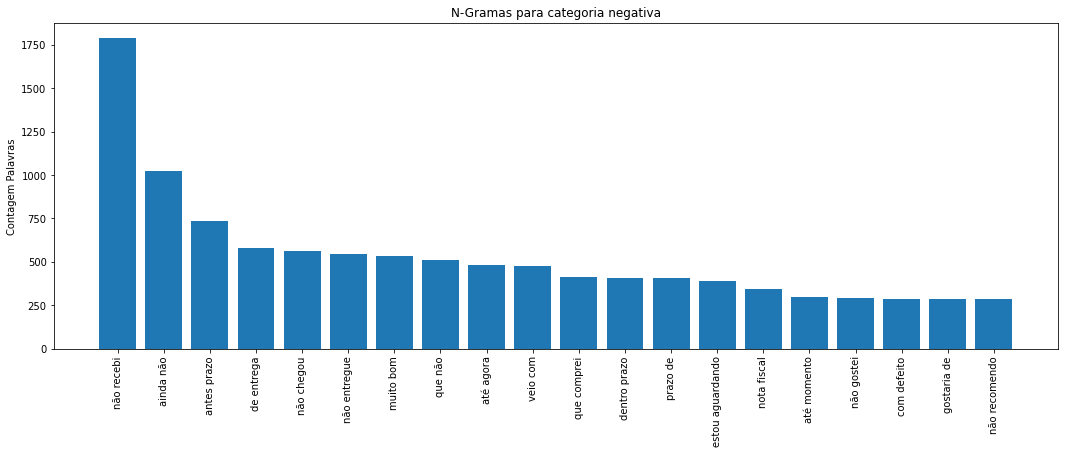

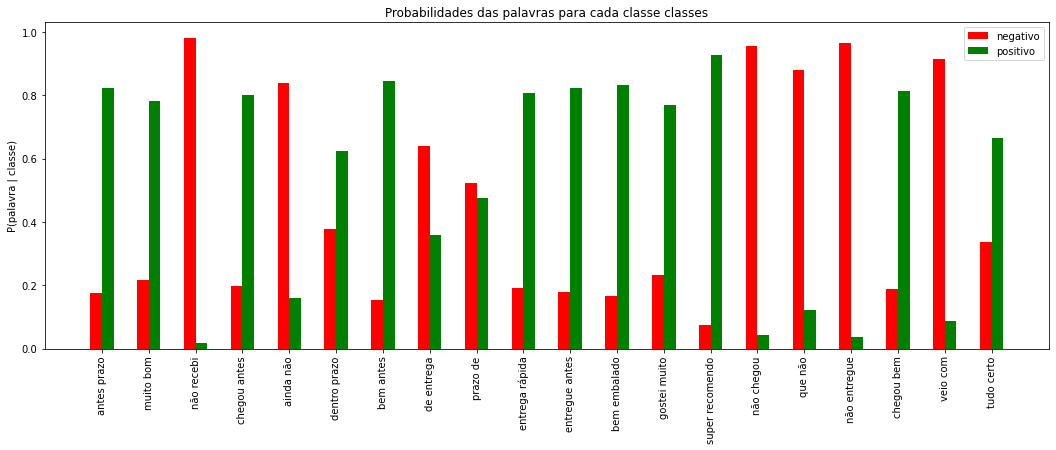

In [9]:
plot_combined(*analyze(all_reviews,good_reviews,bad_reviews,n=20,ngram_range=(2,2)))

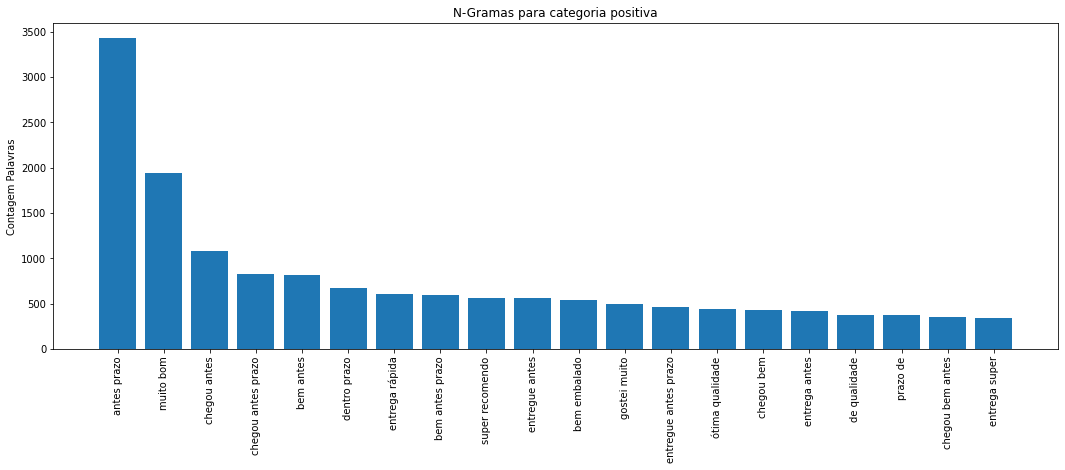

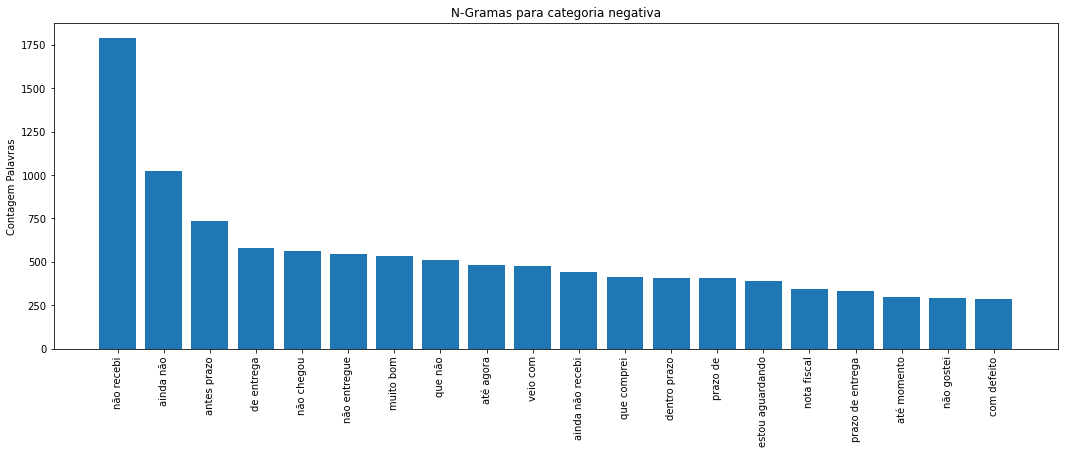

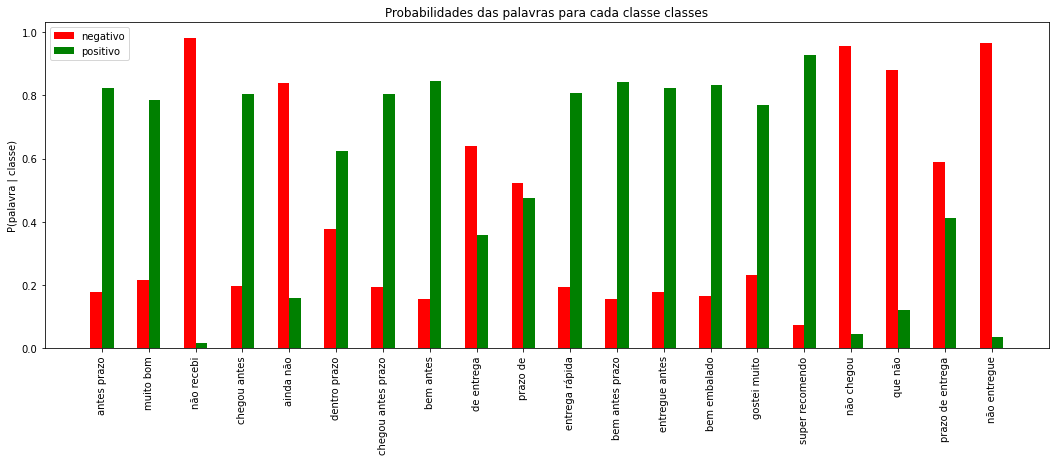

In [10]:
plot_combined(*analyze(all_reviews,good_reviews,bad_reviews,n=20,ngram_range=(2,3)))

E após analisar casos com apenas bigramas e ngramas de tamanho 2 e 3, fica bem evidente que esse tipo de problema é muito central para os dados em questão.

## Conclusão

A partir da análise acima, pode-se dizer que a hipótese era razoavelmente válida.

Pode-se sugerir a empresas como a Olist, que sejam mais cuidadosos com anunciar produtos de vendedores novos, e que de forma geral, a pior coisa imaginável para vendedores/revendedores/anunciantes é a não entrega de um produto. A entrega atrasada é bastante ruim também, mas a não entrega é o que gera mais comentários negativos. Além disso, existe um trigrama "de boa qualidade" que aparenta ter alguma significância entre os dados. Pode ser que garantia de qualidade dos produtos seja algo que deve ser mantido como importante dentro das vias de conduta da empresa, apesar de que muitas vezes isso não é tão acionável, pois depende mais do fabricante e do tipo de produto em si do que do revendedor, mas ainda assim.